# Imports and setting up viz

NB : conda env1 on PC, lam1env on spirit (Python3.12)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
from tools import *

# Load and edit files

LAM output analysis.

simu irr et simu no-irr.

## Sims

In [2]:
noirr_dir='../../../JZ_simu_outputs/LAM/noirr_2010_2022'
irr_dir='../../../JZ_simu_outputs/LAM/irr_2010_2022'

In [3]:
# #open netcdf files for native routing on orc grid
# filename = '{}/SRF/MO/*history.nc'.format(noirr_dir)
# orc0 = xr.open_mfdataset(filename)
# #name
# orc0.attrs['name'] = 'no_irr'
# #time counter
# orc = orc0.rename({'time_counter':'time'})
# #define vars
# orc['totrunoff'] = orc['runoff'] + orc['drainage']
# # limit data to lon and lat of interest (-13,6) and (32,49)
# # orc = orc.sel(lon=slice(-13,6),lat=slice(32,49))
# orc


In [4]:
# filename = '{}/SRF/MO/*history.nc'.format(irr_dir)
# orc0irr = xr.open_mfdataset(filename)
# #name
# orc0irr.attrs['name'] = 'irr'
# #time counter
# orcirr = orc0irr.rename({'time_counter':'time'})
# #define vars
# orcirr['totrunoff'] = orcirr['runoff'] + orcirr['drainage']
# # limit data to lon and lat of interest (-13,6) and (32,49)
# # orc = orc.sel(lon=slice(-13,6),lat=slice(32,49))
# orcirr

In [25]:
#sim
filename = '{}/ATM/TS*.nc'.format(noirr_dir)
# filename = '{}/ATM/MO/*.nc'.format(noirr_dir)

sim0 = xr.open_mfdataset(filename)
sim0.attrs['name'] = 'no_irr'
sim = sim0.rename({'time_counter':'time'})
sim = sim.sel(lon=slice(-13,6),lat=slice(32,49))

sim['evap'] = sim['evap'] *3600 * 24
sim['evap'].attrs['units'] = 'mm/d'

sim['precip'] = sim['precip'] *3600 * 24
sim['precip'].attrs['units'] = 'mm/d'

sim['fluxsens']= -sim['sens']

sim['netrad'] = sim['LWdnSFC'] - sim['LWupSFC'] + sim['SWdnSFC'] - sim['SWupSFC']
sim['netrad'].attrs['units'] = 'W/m2'

sim['convergence'] = sim['precip'] - sim['evap']
sim['convergence'].attrs['units'] = 'mm/d'

sim

<xarray.Dataset>
Dimensions:               (klevp1: 80, bnds: 2, klev: 79, lat: 170, lon: 181,
                           time: 156, axis_nbounds: 2)
Coordinates:
  * klevp1                (klevp1) float64 1.0 2.0 3.0 4.0 ... 78.0 79.0 80.0
  * bnds                  (bnds) float32 1.0 2.0
  * klev                  (klev) float64 1.0 2.0 3.0 4.0 ... 76.0 77.0 78.0 79.0
  * lat                   (lat) float32 32.01 32.11 32.21 ... 48.79 48.89 48.99
  * lon                   (lon) float32 -13.0 -12.89 -12.79 ... 5.889 5.995
  * time                  (time) datetime64[ns] 2010-01-16T12:00:00 ... 2022-...
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    time_instant          (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables: (12/81)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    Ahyb                  (time, klevp1) float32 dask.array<chunksize=(1, 80), meta=np.ndarray>
    Ahyb_bounds           (time, bnds, klevp1) float32 dask.array<chunksize=(1, 2, 80), meta=np.ndarray>
    Bhyb                  (time, klevp1) float32 dask.array<chunksize=(1, 80), meta=np.ndarray>
    ...                    ...
    z700                  (time, lat, lon) float32 dask.array<chunksize=(1, 170, 181), meta=np.ndarray>
    z500                  (time, lat, lon) float32 dask.array<chunksize=(1, 170, 181), meta=np.ndarray>
    z200                  (time, lat, lon) float32 dask.array<chunksize=(1, 170, 181), meta=np.ndarray>
    fluxsens              (time, lat, lon) float32 dask.array<chunksize=(1, 170, 181), meta=np.ndarray>
    netrad                (time, lat, lon) float32 dask.array<chunksize=(1, 170, 181), meta=np.ndarray>
    convergence           (time, lat, lon) float32 dask.array<chunksize=(1, 170, 181), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-11 06:26:42 GMT
    uuid:         53a3dfb8-398d-4d5d-ac15-f869740c6a6c

In [56]:
#sim irr
filename = '{}/ATM/TS*.nc'.format(irr_dir)
# filename = '{}/ATM/MO/*.nc'.format(irr_dir)

sim0irr = xr.open_mfdataset(filename)
sim0irr.attrs['name'] = 'irr'
simirr = sim0irr.rename({'time_counter':'time'})
simirr = simirr.sel(lon=slice(-13,6),lat=slice(32,49))

simirr['evap'] = simirr['evap'] *3600 * 24
simirr['evap'].attrs['units'] = 'mm/d'

simirr['precip'] = simirr['precip'] *3600 * 24
simirr['precip'].attrs['units'] = 'mm/d'

simirr['fluxsens']= -simirr['sens']

simirr['netrad'] = simirr['LWdnSFC'] - simirr['LWupSFC'] + simirr['SWdnSFC'] - simirr['SWupSFC']
simirr['netrad'].attrs['units'] = 'W/m2'

simirr['convergence'] = simirr['precip'] - simirr['evap']
simirr['convergence'].attrs['units'] = 'mm/d'

simirr


KeyboardInterrupt: 

## Obs

In [7]:
#open ERA5 file
filename = '../../../obs/ERA5_eval_2010_2022.nc'
era = xr.open_mfdataset(filename)
era.attrs['name'] = 'ERA5'
#define or edit vars
#name ERA5 vars like in LMDZOR outputs
dict =  {
        'longitude':'lon',
        'latitude':'lat',
        'e':'evap',
        'ro':'totrunoff',
        'tp':'precip'
        }
era = era.rename(dict)

#make evap positive in era
era['evap'] = -era['evap'] * 1000
era['evap'].attrs['units'] = 'mm/d'
era['precip'] = era['precip']*1000
era['precip'].attrs['units'] = 'mm/d'
era['cldt'] = era['tcc']*100
era['cldt'].attrs['units'] = '%'

era['convergence'] = era['precip'] - era['evap']
era['convergence'].attrs['units'] = 'mm/d'

era


<xarray.Dataset>
Dimensions:      (lon: 77, lat: 69, time: 156)
Coordinates:
  * lon          (lon) float32 -13.0 -12.75 -12.5 -12.25 ... 5.25 5.5 5.75 6.0
  * lat          (lat) float32 49.0 48.75 48.5 48.25 ... 32.75 32.5 32.25 32.0
  * time         (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
Data variables:
    u10          (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    v10          (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    t2m          (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    evap         (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    totrunoff    (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    precip       (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    tcc          (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    cldt         (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    convergence  (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6
    history:                    Wed Jul  3 12:49:08 2024: ncks -A extracted_t...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...
    history_of_appended_files:  Wed Jul  3 12:49:08 2024: Appended file extra...
    name:                       ERA5

In [8]:
#gleam
filename='../../../obs/evap/E_1980-2022_GLEAM_v3.8a_MO.nc'
gleam0=xr.open_dataset(filename)
gleam0.attrs['name']='GLEAM'
gleam = gleam0.sel(lon=slice(-13,6),lat=slice(49,32))
#adapt period
gleam=gleam.sel(time=slice('2010-01-01', '2022-12-31'))
#name gleam vars like in LMDZOR outputs
dict =  {
        'E':'evap'
        }
gleam = gleam.rename(dict)
#convert mm/month to mm/day
gleam['evap']=gleam['evap']/30
gleam['evap'].attrs['units']='mm/d'
gleam

<xarray.Dataset>
Dimensions:  (time: 156, lon: 76, lat: 68)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2022-12-31
  * lon      (lon) float64 -12.88 -12.62 -12.38 -12.12 ... 5.375 5.625 5.875
  * lat      (lat) float64 48.88 48.62 48.38 48.12 ... 32.88 32.62 32.38 32.12
Data variables:
    evap     (time, lat, lon) float32 nan nan nan nan ... 0.06059 0.05702 0.0631
Attributes:
    name:     GLEAM

In [9]:
filename='../../..//obs/FluxCom/ensemble_rs-_meteo_ALL/monthly/*.RS_METEO.EBC-*.MLM-ALL.METEO-ALL.720_360.monthly.*.nc'
fluxcom0=xr.open_mfdataset(filename)
fluxcom=fluxcom0.sel(lon=slice(-13,6.25),lat=slice(49,32))
fluxcom=fluxcom.sel(time=slice('2010-01-01', '2022-12-31'))

fluxcom.attrs["name"]='FluxCom'

fluxcom['evap'] = fluxcom['LE'] * 0.408 # To convert from MJ/m2/d to mm/d
fluxcom['evap'].attrs['units'] = 'mm/d'

fluxcom['fluxlat'] = fluxcom['LE'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['fluxlat'].attrs['units'] = 'W/m²'

fluxcom['fluxsens'] = fluxcom['H'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['fluxsens'].attrs['units'] = 'W/m²'

fluxcom['netrad'] = fluxcom['Rn'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['netrad'].attrs['units'] = 'W/m²'
fluxcom

<xarray.Dataset>
Dimensions:    (time: 48, lat: 34, lon: 39, nbnds: 2)
Coordinates:
  * lon        (lon) float64 -12.75 -12.25 -11.75 -11.25 ... 4.75 5.25 5.75 6.25
  * lat        (lat) float64 48.75 48.25 47.75 47.25 ... 33.75 33.25 32.75 32.25
  * time       (time) datetime64[ns] 2010-01-16 2010-02-16 ... 2013-12-16
Dimensions without coordinates: nbnds
Data variables: (12/16)
    H          (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    H_mad      (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    H_n        (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    lat_bnds   (time, lat, nbnds) float64 dask.array<chunksize=(12, 34, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnds) float64 dask.array<chunksize=(12, 39, 2), meta=np.ndarray>
    time_bnds  (time, nbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    ...         ...
    Rn_mad     (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    Rn_n       (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    evap       (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    fluxlat    (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    fluxsens   (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
    netrad     (time, lat, lon) float32 dask.array<chunksize=(12, 34, 39), meta=np.ndarray>
Attributes: (12/16)
    Comment:                        Ensemble median of 36 members
    Energy_Balance_Correction_EBC:  NONE, BWR, RES
    Machine_Learning_Method_MLM:    RF, ANN, MARS
    Meteorolgical_Data_METEO:       CRUNCEP_v8, WFDEI, CERES_GPCP, GSWP3
    Version:                        v1
    SETUP:                          RS_METEO
    ...                             ...
    Institution:                    MPI-BGC-BGI
    Provided_By:                    Martin Jung [mjung@bgc-jena.mpg.de] on be...
    Created_By:                     Fabian Gans [fgans@bgc-jena.mpg.de], Ulri...
    Temporal_Aggregation_Method:    first interpolate to daily,  second aggre...
    History:                        created: Mon Mar 18 15:20:10 2019
    name:                           FluxCom

In [10]:
#gpcc
filename='../../../obs/precips/precip.mon.total.0.25x0.25.v2020.nc'
gpcc0=xr.open_mfdataset(filename)
gpcc0.attrs['name'] = 'GPCC'
gpcc=gpcc0.sel(time=slice('2010-01-01', '2022-12-31'))
gpcc['lon'] = ((gpcc['lon'] + 180) % 360) - 180
gpcc1 = gpcc.sortby('lon')

# gpcc=gpcc.sel(lon=slice(-13,6.25),lat=slice(32,49))
gpcc=gpcc1.sel(lon=slice(-13,6.25),lat=slice(49,32))

# gpcc1=gpcc.sel(lon=slice(347,360),lat=slice(49,32))
# gpcc2=gpcc.sel(lon=slice(0,6.25),lat=slice(49,32))
# gpcc=xr.combine_by_coords([gpcc1, gpcc2])
# gpcc = gpcc.where(gpcc['lon'] < 6.25, drop=True)

# gpcc['lon']=gpcc['lon']-180.0
# gpcc=gpcc.sel(lon=slice(-13,6.25))

gpcc['precip'] = gpcc['precip'] / 30 #convert to mm/d
gpcc['precip'].attrs['units'] = 'mm/d'
gpcc

<xarray.Dataset>
Dimensions:  (lat: 68, lon: 77, time: 120)
Coordinates:
  * lat      (lat) float32 48.88 48.62 48.38 48.12 ... 32.88 32.62 32.38 32.12
  * lon      (lon) float32 -12.88 -12.62 -12.38 -12.12 ... 5.625 5.875 6.125
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(120, 68, 77), meta=np.ndarray>
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulldata_downl...
    Conventions:      CF 1.0
    dataset_title:    Global Precipitation Climatology Centre (GPCC)
    title:            GPCC Full Data Reanalysis Version 2020 0.25x0.25 Monthl...
    history:          Created 07/2021  based on V2020 data obtained via wget
    References:       https://www.psl.noaa.gov/data/gridded/data.gpcc.html
    name:             GPCC

In [33]:
#open tqruv file
filename='../../../obs/TQRUV_850_2010_2022_monthly.nc'
tqruv = xr.open_dataset(filename)
tqruv.attrs['name'] = 'ERA5'
tqruv = tqruv.sel(longitude=slice(-13,6),latitude=slice(49,32))
#rename longitude and latitude to lon and lat
tqruv = tqruv.rename({'longitude':'lon','latitude':'lat'})

#rename all variables to add 850 in name
tqruv['u850'] = tqruv['u']
tqruv['v850'] = tqruv['v']
tqruv['q850'] = tqruv['q']
tqruv['t850'] = tqruv['t']
tqruv['r850'] = tqruv['r']
tqruv

<xarray.Dataset>
Dimensions:    (time: 156, bnds: 2, lon: 77, lat: 69, level: 1)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-16T11:00:00 ... 2022-12-16T11:00:00
  * lon        (lon) float32 -13.0 -12.75 -12.5 -12.25 ... 5.25 5.5 5.75 6.0
  * lat        (lat) float32 49.0 48.75 48.5 48.25 ... 32.75 32.5 32.25 32.0
  * level      (level) float64 850.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    t          (time, level, lat, lon) float32 ...
    q          (time, level, lat, lon) float32 ...
    r          (time, level, lat, lon) float32 ...
    u          (time, level, lat, lon) float32 ...
    v          (time, level, lat, lon) float32 ...
    u850       (time, level, lat, lon) float32 ...
    v850       (time, level, lat, lon) float32 ...
    q850       (time, level, lat, lon) float32 ...
    t850       (time, level, lat, lon) float32 ...
    r850       (time, level, lat, lon) float32 ...
Attributes:
    CDI:                         Climate Data Interface version 1.9.8 (https:...
    Conventions:                 CF-1.6
    history:                     Fri Jul 12 16:41:50 2024: cdo monmean TQRUV_...
    source:                      credit: ECMWF, COPERNICUS Climate Change Ser...
    title:                       ERA5 reanalysis
    data_type:                   hourly fields analysis
    grid_resolution_in_degrees:  0.25
    NCO:                         netCDF Operators version 4.8.1 (Homepage = h...
    history_of_appended_files:   Fri Mar 29 16:23:15 2024: Appended file tmp_...
    frequency:                   mon
    CDO:                         Climate Data Operators version 1.9.8 (https:...
    name:                        ERA5

# Masking, interpolation, and time period selection

In [12]:
# Select months
# months=[7]

# orc = orc.sel(time=orc['time.month'].isin(months))
# orcirr = orcirr.sel(time=orcirr['time.month'].isin(months))

# sim = sim.sel(time=sim['time.month'].isin(months))
# simirr = simirr.sel(time=simirr['time.month'].isin(months))

# era = era.sel(time=era['time.month'].isin(months))
# fluxcom=fluxcom.sel(time=fluxcom['time.month'].isin(months))

In [13]:
#continental fraction mask (LMDZ outputs)
con_mask=sim['contfracATM']>0.9

#create a masks of data points where irrig_frac >5%
# irr_mask = (orcirr['irrigmap_dyn']/orcirr['Areas'])>0.05
irr_mask = con_mask

ip_mask=polygon_to_mask(sim, iberic_peninsula)
# ip_mask_orc=polygon_to_mask(orc, iberic_peninsula)

In [14]:
cont_sim=sim.where(con_mask)
cont_simirr=simirr.where(con_mask)

ip_sim = sim.where(ip_mask['mask'], drop=False).where(con_mask)
ip_simirr = simirr.where(ip_mask['mask'], drop=False).where(con_mask)

# ip_orc=orc.where(ip_mask_orc['mask'], drop=False)

In [40]:
sim_era = sim.interp_like(era)
sim_gpcc = sim.interp_like(gpcc)
sim_gleam = sim.interp_like(gleam)
sim_fluxcom = sim.interp_like(fluxcom)
sim_tqruv = sim.interp_like(tqruv)

simirr_era = simirr.interp_like(era)
simirr_gpcc = simirr.interp_like(gpcc)
simirr_gleam = simirr.interp_like(gleam)
simirr_fluxcom = simirr.interp_like(fluxcom)
simirr_tqruv = simirr.interp_like(tqruv)

ip_sim_era = ip_sim.interp_like(era)
ip_sim_gpcc = ip_sim.interp_like(gpcc)
ip_sim_gleam = ip_sim.interp_like(gleam)
ip_sim_fluxcom = ip_sim.interp_like(fluxcom)
ip_sim_tqruv = ip_sim.interp_like(tqruv)

ip_simirr_era = ip_simirr.interp_like(era)
ip_simirr_gpcc = ip_simirr.interp_like(gpcc)
ip_simirr_gleam = ip_simirr.interp_like(gleam)
ip_simirr_fluxcom = ip_simirr.interp_like(fluxcom)
ip_simirr_tqruv = ip_simirr.interp_like(tqruv)

In [16]:
# irrorc=orc.where(irr_mask)
# irrorcirr=orcirr.where(irr_mask)

In [17]:
# era
int_era=era.interp_like(sim)
cont_era=int_era.where(con_mask)
ip_era = cont_era.where(ip_mask['mask'], drop=False)
# orc_era=era.interp_like(orc)

In [18]:
#gleam
int_gleam=gleam.interp_like(sim)
cont_gleam=gleam.interp_like(sim).where(con_mask)
ip_gleam = cont_gleam.where(ip_mask['mask'], drop=False)
# irr_era=era.interp_like(orc).where(irr_mask)
# irr_gleam=gleam.interp_like(orc).where(irr_mask)

In [19]:
#fluxcom
int_fluxcom=fluxcom.interp_like(sim)
cont_fluxcom=fluxcom.interp_like(sim).where(con_mask)
ip_fluxcom = cont_fluxcom.where(ip_mask['mask'], drop=False)
# orc_fluxcom=fluxcom.interp_like(orc)

In [20]:
#gpcc
int_gpcc=gpcc.interp_like(sim)
cont_gpcc=gpcc.interp_like(sim).where(con_mask)
ip_gpcc = cont_gpcc.where(ip_mask['mask'], drop=False)

In [34]:
int_tqruv = tqruv.interp_like(sim)
cont_tqruv = tqruv.interp_like(sim).where(con_mask)
ip_tqruv = cont_tqruv.where(ip_mask['mask'], drop=False)

# Maps

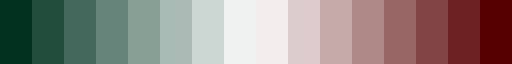

In [21]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom colormap

cmap = LinearSegmentedColormap.from_list(
    "custom_green_red",
    ["#013220", "white",  "#550000"]  # Very dark green, white, dark red, almost black
)
ferret_eq=ListedColormap(cmap(np.linspace(0, 1, 16)))
ferret_eq

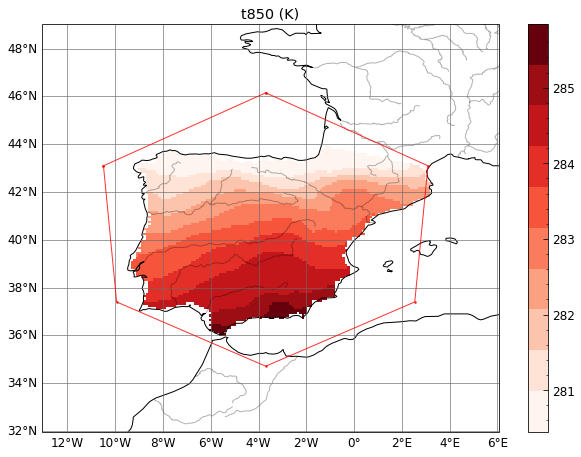

In [36]:
#Display map of var for ds
var='t850'
ds=ip_tqruv
#select only year 2014
# ds = ds.sel(time=ds['time.year'] == 2014)
color_map=reds
max_value=None

map_ave(ds, var, in_cmap=color_map, in_vmax=max_value, hex=True)

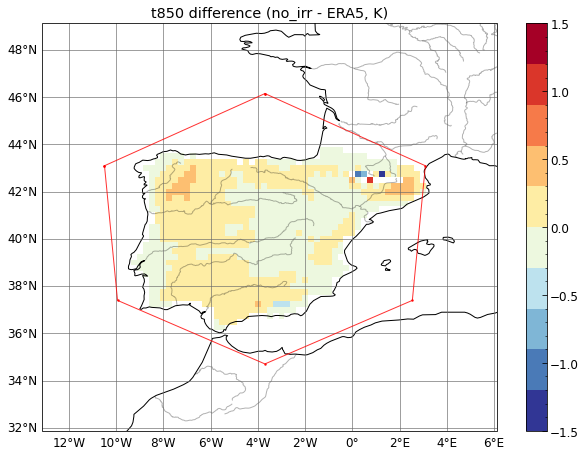

In [47]:
#Diff map
var='t850'
max_value=1.5
months=[1,2,3,4,5,6,7,8,9,10,11,12]
ds1=ip_sim_tqruv
ds2=tqruv
ds1=ds1.sel(time=ds1['time.month'].isin(months))
ds2=ds2.sel(time=ds2['time.month'].isin(months))

map_diff_ave(ds1, ds2, var, in_vmax=max_value, hex=True, sig=False)

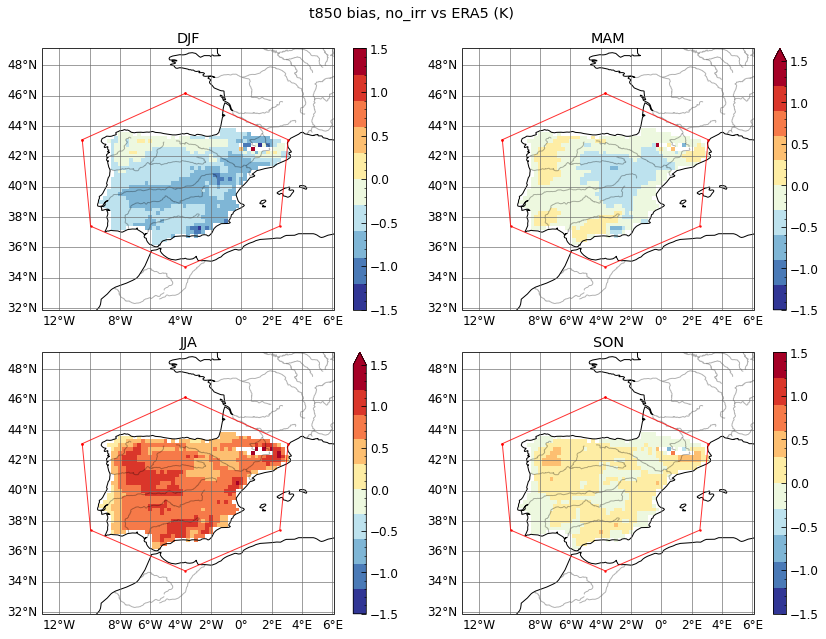

In [50]:
#map for 4 seasons
var='t850'
ds1=ip_sim_tqruv
ds2=tqruv
max_value=1.5

diff=ds1[var]-ds2[var]
title='{} bias, {} vs {} ({})'.format( var, ds1.attrs['name'], ds2.attrs['name'], ds1[var].attrs['units'])

plotvar=diff
map_seasons(plotvar, in_cmap=emb, in_vmax=max_value, in_vmin=-1.5, in_title=title, hex=True)

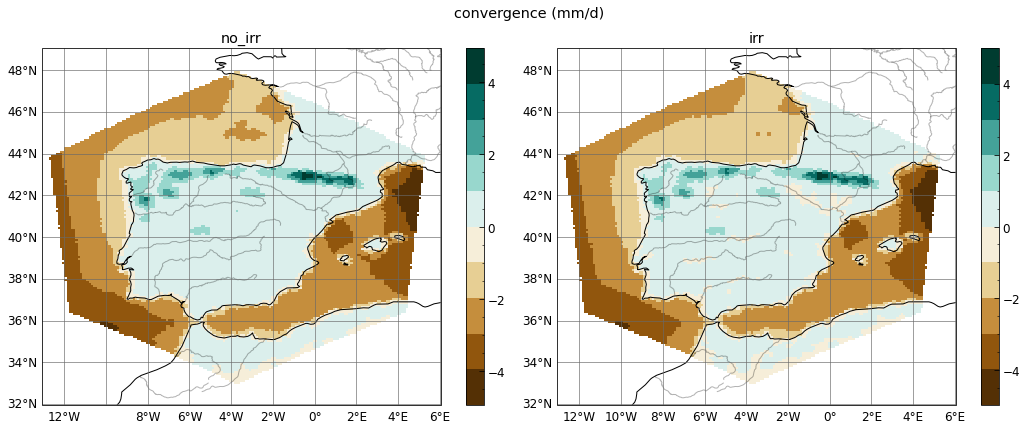

In [ ]:
# Display 2 maps of var
var = 'convergence'
min_value=None
max_value=None
color_map=emb_neutral
ds1=sim
ds2=simirr
map_two_ds(ds1, ds2, var, in_vmin=min_value, in_figsize=(15,6), in_vmax=max_value, in_cmap=color_map)

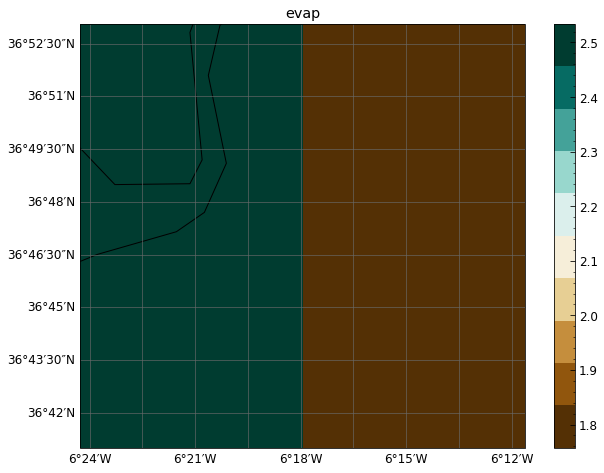

In [ ]:
#Display map of var for ds on restricted area
var='evap'
ds = sim
latmin=36.7
latmax=36.9
lonmin=-6.4
lonmax=-6.2

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True).where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True).where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
map_plotvar(plotvar, in_cmap=emb_neutral, in_vmax=None, in_title=var)

KeyError: 'precip'

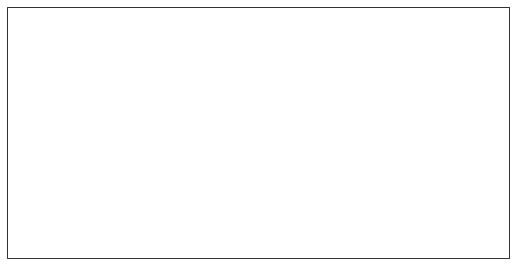

In [ ]:
#Relative diff map
var='precip'
max_value=None
ds1=cont_fluxcom
ds2=ip_fluxcom
# plt.title('Gross primary production relative difference (%)')
map_rel_diff_ave(ds1, ds2, var, in_vmax=max_value)

# Time series

no_irr : 282.83 (K)
irr : 282.84 (K)


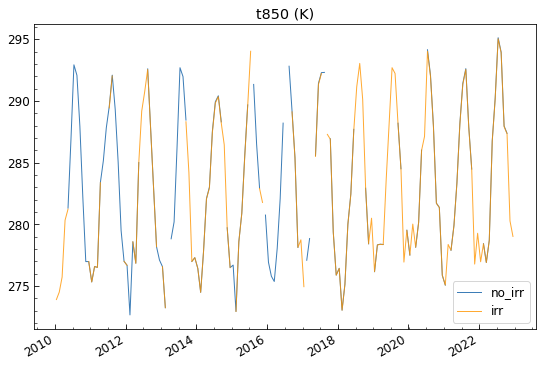

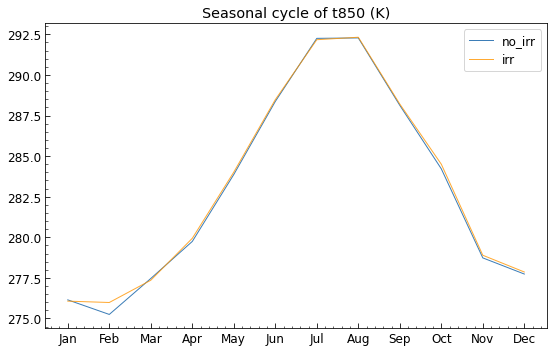

In [55]:
var='t850'

ds1=ip_sim
ds2=ip_simirr
ds3=ip_era
ds3=ip_fluxcom
ds5=ip_gleam

# ds1=ip_orc
# ds2=ip_orcirr
# ds3=ip_fluxcom_orc


ds3=ip_tqruv

ds_list=[ds1, ds2]#, ds3]#, ds4, ds5]
# ds_list=[ds2]

year_max=2022
time_series(ds_list, var, year_max=year_max, in_title='{} ({})'.format(var, ds1[var].attrs['units']))
seasonal_cycle(ds_list, var, year_max=year_max, in_title='Seasonal cycle of {} ({})'.format(var, ds1[var].attrs['units']))